# milestone2

In [1]:
import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from wordcloud import WordCloud
from textrazor import TextRazor
from tqdm import tqdm
from urllib.parse import urlparse
from datetime import datetime
from dateutil.parser import parse
from collections import OrderedDict, Counter
import pandas as pd
import json
import numpy as np
import plotly.io as pio
from IPython import display




sns.set()
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elenath/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/elenath/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/elenath/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /Users/elenath/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

## 1. dataset analysis

As for datasets, basically we only use the quotebank dataset and the wikidata dataset, so the following analysis will mainly focus on the two parts.

### 1.1 handling data in its size

The dataset files we will use are as follow:  
|                Dataset               |   Size   |
|:------------------------------------:|:--------:|
|         quotes-2015.json.bz2         |  3.3 GB  |
|         quotes-2016.json.bz2         |  2.3 GB  |
|         quotes-2017.json.bz2         |  5.2 GB  |
|         quotes-2018.json.bz2         |  4.8 GB  |
|         quotes-2019.json.bz2         |  3.6 GB  |
|         quotes-2020.json.bz2         | 830.7 MB |
|      speaker_attributes.parquet      | 294.6 MB |
| wikidata_labels_descriptions.csv.bz2 |  1.7 GB  |

From the table, we can see that basically all the quotes files and the wikidata files are just too large to put into memory. Therefore, we will deal with those files in chunks (e.g. 1000000 lines each time). But for the `speaker_attributes.parquet` file we can just load the whole file into memory and carry out the operations. Experiments show that the loading and operating on those datasets work well on our 16GB RAM laptops.  

### 1.2 datasets analysis

First we list the overall structure of the dataset with the features that we gonna use.

```
QuoteBank potential using Features:
|-- quoteID: Identify each quotation, used for mapping or checking duplicity
|-- quotation: Quotation which we mainly used for analysis
|-- date: datetime used for time-related analysis
|-- speaker: speaker with the most possibility
|-- qids: Wikidata IDs of all aliases that match the selected speaker
|-- urls: source url of quotation which we use for media and context analysis 
```

In [17]:
# load the sample dataset
df = pd.read_json("data/quotes-2019-nytimes.json", lines=True)
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2019-04-17-024782,"It is not a low-income immigration,",James Fisher,"[Q16213953, Q20707104, Q43143598, Q58886302, Q...",2019-04-17 13:31:18,1,"[[James Fisher, 0.7475], [None, 0.2525]]",[https://www.nytimes.com/2019/04/17/realestate...,E
1,2019-04-02-001128,a champion figure skater switching to roller s...,John Updike,[Q105756],2019-04-02 14:58:33,2,"[[John Updike, 0.5856], [None, 0.4144]]",[https://www.nytimes.com/2019/04/02/opinion/vl...,E
2,2019-05-09-055187,It makes it much more difficult for him to mak...,None,[],2019-05-09 18:11:29,1,"[[None, 0.6493], [President Bill Clinton, 0.27...",[http://mobile.nytimes.com/2019/05/09/world/as...,E
3,2019-10-31-056366,"It puts me in a predicament,",Xavier Becerra,[Q1855840],2019-10-31 16:45:15,3,"[[Xavier Becerra, 0.9065], [None, 0.0909], [St...",[http://www.nytimes.com/2019/10/31/technology/...,E
4,2019-01-04-001792,A Pile of Leaves.,None,[],2019-01-04 10:00:07,1,"[[None, 0.8737], [Jason Fulford, 0.1263]]",[https://www.nytimes.com/2019/01/04/books/revi...,E


In [18]:
df.shape

(207527, 9)

In [19]:
# list the data types of each column
df.dtypes

quoteID                   object
quotation                 object
speaker                   object
qids                      object
date              datetime64[ns]
numOccurrences             int64
probas                    object
urls                      object
phase                     object
dtype: object

#### Discuss about None value
As seen in the shown dataframe, there are 'None' values in 'speaker' and 'qids' columns. In 'speaker', the None value represents that there are no predicted speakers, which corresponds to the empty list in the 'qid' column

Then we conduct initial data wrangling and analysis as:
### 1. dataset overall analysis
   1. quotation frequency related to topics (exclude None speaker)
   2. quotation frequency related to time
   3. quotation frequency related to speaker
   4. quotation frequency of certain speaker (used for filter topics)
### 2. From 2019 Data to our topic
   1. We want to focus on something easily ignored by the main media
   2. But not so negligible, and should not be

### Helper functions
Here we define some tool functions that will be used later in our analysis

#### Note about Method of functions related to topic extraction

Firstly we tried to use pre-trained language models such as BERT and TopicBERT to extract topics based on aggregation. However, such a method is not efficient enough to tackle such enormous data, and the accuracy depends on the pre-trained weight which may require transfer learning on a new dataset with some labeled data. 

Therefore, we switch to the help of grammar analysis as used in NLTK. 

In [20]:
def get_s_quote_list(df):
    """
    get the quotation list with speakers != None
    """
    quote_list = df[df['speaker'] != 'None']['quotation'].str.strip().to_numpy()  # consider only non_None speakers
    
    return quote_list

def get_nouns(text):
    """
    extract nouns from a piece of text/quotation
    """
    text = "".join([ch for ch in text if ch not in string.punctuation])
    text_no_stop = " ".join(w.lower() for w in text.strip().split(" ") if w not in stopwords.words('english'))
    tokenized = nltk.word_tokenize(text_no_stop)
    nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if pos[:2] == "NN"]
    return nouns

def blob_get_nouns(text):
    """
    extract nouns from a piece of text/quotation using textblob (based on NLTK)
    """
    # this noun extraction is based on grammar analysis 
    # so we do not perform stopword removement
    b_text = TextBlob(text)  
    return b_text.noun_phrases

def count_topic_freq(quote, exis_dict):
    """
    count the topic frequency and store in the exis_dict

    :param quote: quote text
    :param exis_dict: dict used to store the frequency
    """
    # find nouns in quotations
    # note that we only count the nouns once in a quotation 
    # (to indicate that the quotation related to the certain noun)
    for noun in blob_get_nouns(quote):
        if noun in STOP_NOUNS or "'" in noun:  # pass meaningless nouns
            continue
        if noun in SYN_MAP.keys():  # map the noun to its synonym
            noun = SYN_MAP[noun]
        if noun in exis_dict.keys():
            exis_dict[noun] += 1
        else:
            exis_dict[noun] = 0

def get_media_from_url(url):
    """
    parse the media/domain name of url

    for example, url='http://www.cwi.nl:80/%7Eguido/Python.html'
    return 'cwi'
    """
    url_parsed = urlparse(url)
    return str(url_parsed.netloc)

In [21]:
# here we define those nouns that is unrelated to any meaningful topic, but appear with high frequency

STOP_NOUNS = {"whether", "right thing","'s kind","'s time", "your","hey","n't need","ca n't", "oh","yeah","o.k", "o.k.", "wo n't", "who", "everyone", "long time", "well", "does", "never"}
SYN_MAP = {'donald trump': 'trump'}

In [22]:
# Analysis functions with dataframe trunks

# Here we define some data analysis functions that could be used with dataframe trunks for gathering certain statistics.

def count_topic_freq_from_list(quote_list, exis_dict=None):
    """
    Count topic frequency of a list of quotations

    :param quote_list: numpy array of quotations
    :param exis_dict: merge the count into existing count dict
    """
    noun_count = exis_dict if exis_dict is not None else {}
    quote_num = len(quote_list)
    print(f'counting quotation topics for {quote_num} quotations ... ')
    for quote in tqdm(quote_list):
        for noun in blob_get_nouns(quote):
            if noun in STOP_NOUNS or "'" in noun:  # pass meaningless nouns
                continue
            if noun in SYN_MAP.keys():  # map the noun to its synonym
                noun = SYN_MAP[noun]
            if noun in noun_count.keys():
                noun_count[noun] += 1
            else:
                noun_count[noun] = 0
    print('finish counting nouns!')

def quote_chunk_freq_analysis(chunk_df, t_count=None, d_count=None, s_count=None, m_count=None):
    """
    Analysis a chunk of data and store the statistics

    :param t_count: topic count dict
    :param d_count: date count dict
    :param s_count: speaker count dict
    :param m_count: media count dict
    """
    chunk_df['date_day'] = chunk_df['date'].dt.date  # keep only date part
    chunk_df['url0'] = chunk_df['urls'].apply(lambda x: x[0]) # keep the first url

    for index, row in tqdm(chunk_df[['quotation','speaker','date_day', 'url0']].iterrows(), total=chunk_df.shape[0]):
        count_topic_freq(row['quotation'], t_count)  # get the topic freq

        date = str(row['date_day'])
        if date in d_count.keys():
            d_count[date] += 1
        else:
            d_count[date] = 0

        speaker = row['speaker']
        if speaker in s_count.keys():
            s_count[speaker] += 1
        else:
            s_count[speaker] = 0

        media = get_media_from_url(row['url0'])
        if media in m_count.keys():
            m_count[media] += 1
        else:
            m_count[media] = 0

### Process data with trunks
As our data can not be fitted into memory at one time, we process the information streamingly as dataframe trunks. (here the sample data could fit into memory but we doing this for building the real data processing pipeline)

In [23]:
t_count = {}
d_count = {}
s_count = {}
m_count = {}

print('processing frequency informations related to topic, date, speaker, media')
quote_chunk_freq_analysis(
    chunk_df = df,
    t_count = t_count,
    d_count = d_count,
    s_count = s_count,
    m_count = m_count
)

processing frequency informations related to topic, date, speaker, media


100%|██████████| 207527/207527 [01:23<00:00, 2489.09it/s]


## 1. topics frequency Analysis (exclude None speaker) 
In this section, we analyze the frequency of topics related to the frequency of the certain noun word appearances in quotations.

Specifically, we count all the possible words and phrases. For example, in the quotation 'trump lives in the white house' we extract the related topic "trump", "white house". The noun word recognition will be based on nltk grammar analysis.

In [24]:
# get the total extracted topic num
topic_num = len(t_count.keys())
print(f'total extracted topic num is {topic_num}')

total extracted topic num is 124885


In [25]:
# sort the nouns according to their appear time
sorted_nouns = list(sorted(t_count.items(), key=lambda x: x[1], reverse=True))

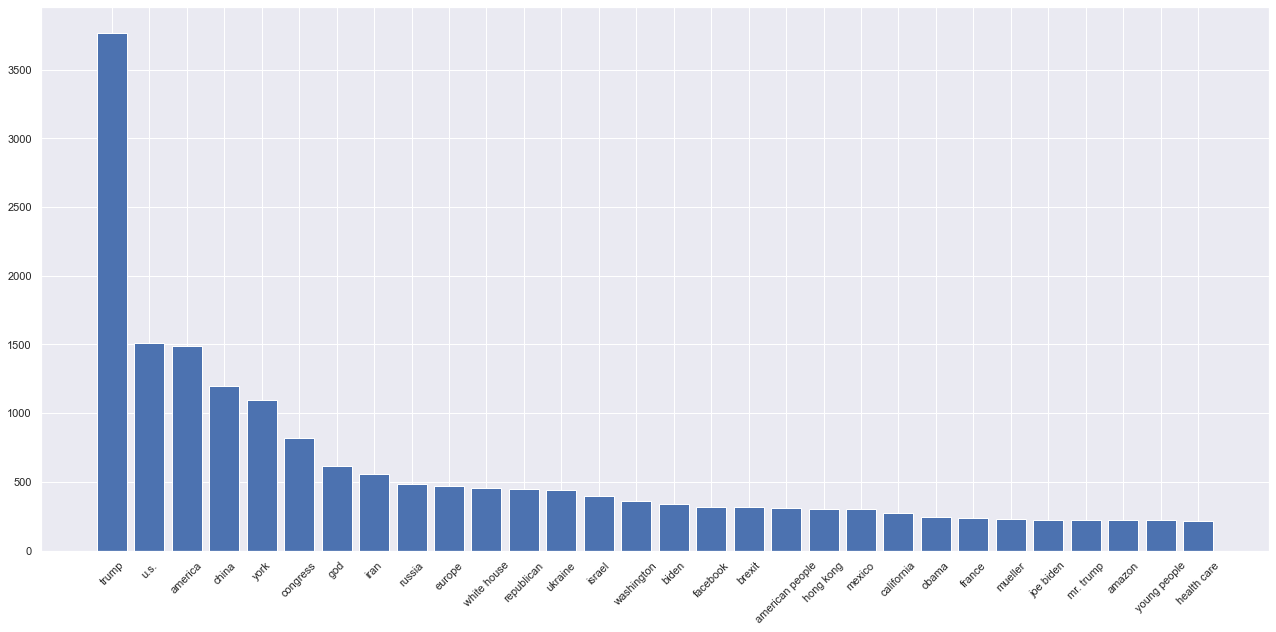

In [26]:
# plot the frequency of top 30 extract topics with respect to frequency
topic_num = 30

top_k_topics = dict(sorted_nouns[:topic_num])
plt.figure(figsize=(22,10))
plt.xticks(rotation=45)
ax = plt.bar(x=list(top_k_topics.keys()), height=list(top_k_topics.values()), data=top_k_topics)

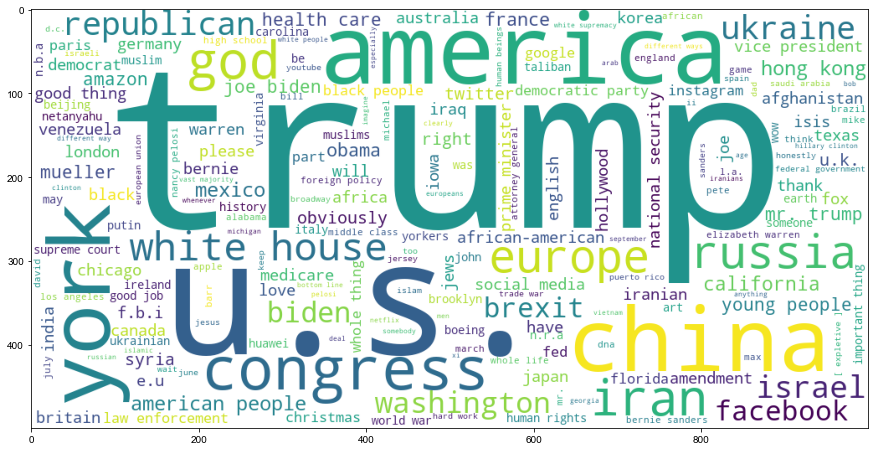

In [27]:
# visualize the word cloud using the topic frequencies
topic_num = 200

top_k_topics = dict(sorted_nouns[:topic_num])  # select top-k topics
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(top_k_topics)
sns.reset_orig()
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
sns.set()

From above we could see that most of the topics extracted from our new york times report are related to politics, including politicians as "Trump" and "Obama", countries as "america" and "israel", and big events such as "brexit" (British exit Europe).

## 2. Time quotation frequency Analysis (exclude None speaker) 
In this section, we analyze the frequency of quotations concerning the time dimension.

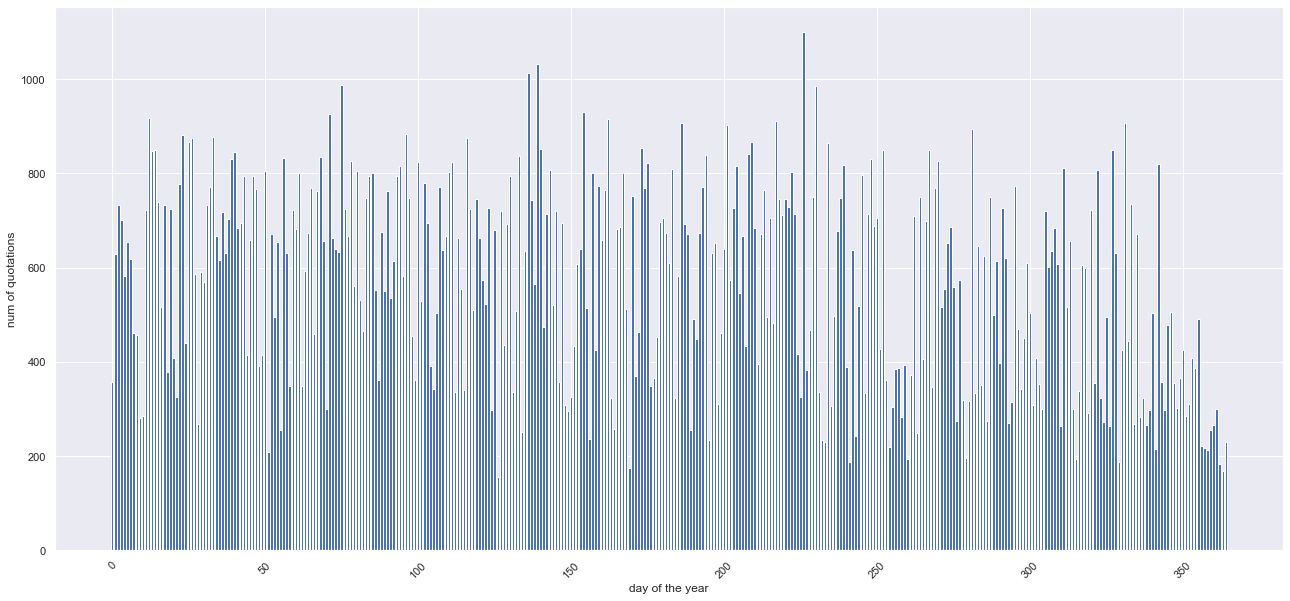

In [28]:
# plot the frequency of quotations with changing time
plt.figure(figsize=(22,10))
plt.xticks(rotation=45)
plt.xlabel('day of the year')
plt.ylabel('num of quotations')
sort_d_count = OrderedDict(sorted(d_count.items(), key= lambda x: parse(x[0])))
ax = plt.bar(x=range(len(sort_d_count.keys())), height=list(d_count.values()), data=sort_d_count)

In [29]:
def combine_day_count(d_count):
    """
    merge the day count to months
    """
    month_count = {}
    for item in d_count.items():
        year_month = '-'.join(item[0].split('-')[:-1])
        if year_month in month_count.keys():
            month_count[year_month] += item[1]
        else:
            month_count[year_month] = 0
    return month_count

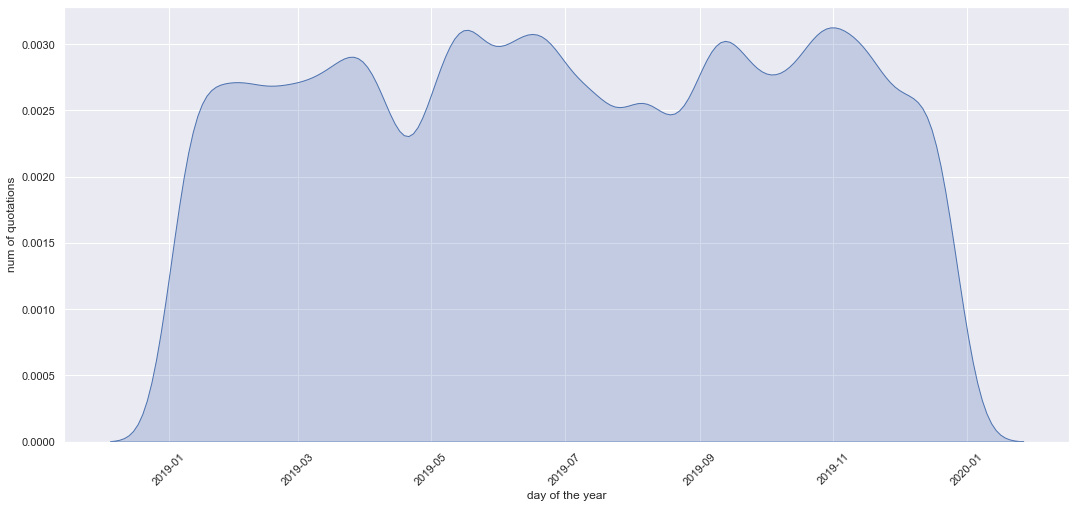

In [30]:
# plot the frequency of quotations with changing time
plt.figure(figsize=(18,8))
plt.xticks(rotation=45)
plt.xlabel('day of the year')
plt.ylabel('num of quotations')
topic_list = [datetime.strptime(x, '%Y-%m-%d') for x in Counter(d_count).elements()]
sns.kdeplot(topic_list, shade=True)

## Quotation frequency with regard to speakers
We visualize the quotation frequency related to different speakers

In [31]:
# sort the names according to their corresponding quotation frequency
sorted_names = list(sorted(s_count.items(), key=lambda x: x[1], reverse=True))[1:]

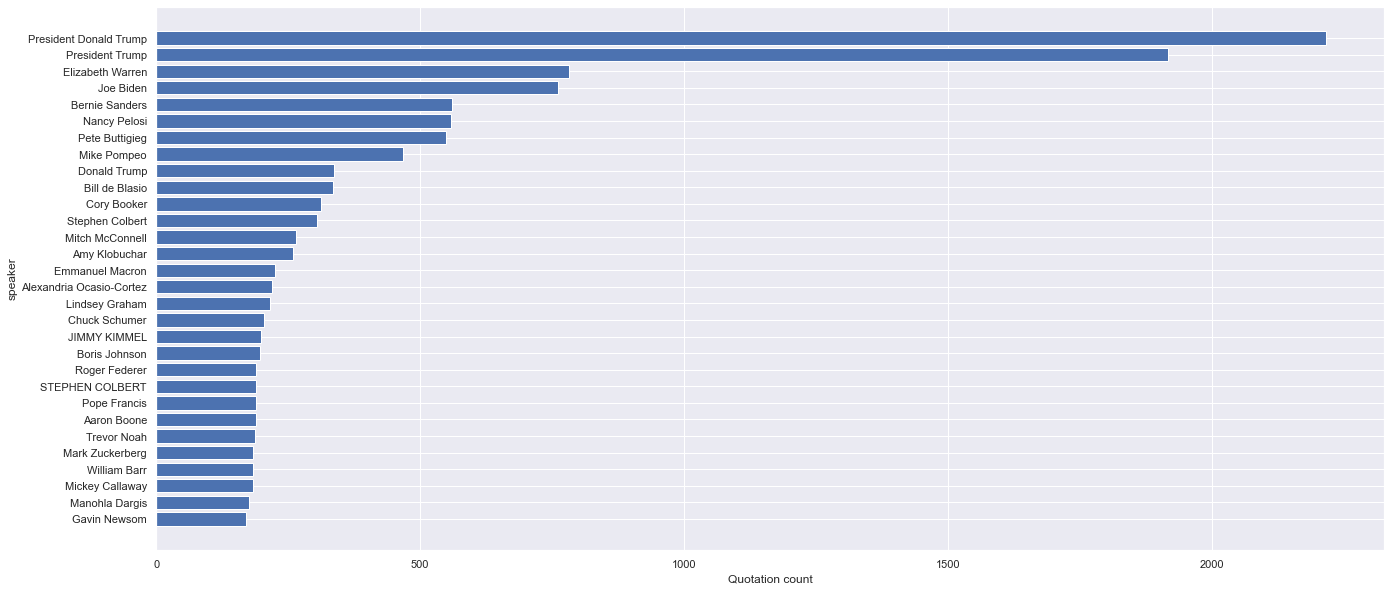

In [32]:
# plot the frequency of top 30 extract topics with respect to frequency
name_num = 30

top_k_topics = dict(sorted_names[:name_num])
plt.figure(figsize=(22,10))
plt.xlabel('Quotation count')
plt.ylabel('speaker')
ax = plt.barh(y=list(top_k_topics.keys())[::-1], width=list(top_k_topics.values())[::-1], data=top_k_topics)

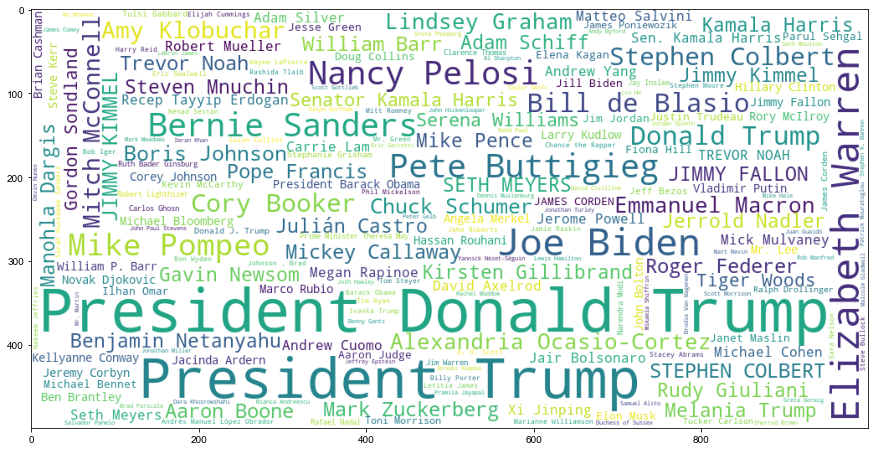

In [33]:
# visualize the speaker word cloud using the quotation frequencies
topic_num = 200

top_k_topics = dict(sorted_names[:topic_num])  # select top-k topics
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(top_k_topics)
sns.reset_orig()
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
sns.set()

Here we notice that there are some people with more than one name annotation (alias). For example, "trump", "President Donald Trump" and "President Trump" may stand for the same person "Donald Trump". This reminds us that we need to build some kind of "alias" dict to map all the synonyms into one entity.

## Quotation frequency with regard to different medias

As we consider different media may contain some certain topic preferences, either aimed at hot news or based on the certain media types (e.g. sports news or entertainment), we visualize the quotation frequency related to different media. 

Here as our sample dataset is from New York Times thus we do not expect any difference here. But by looking at the bigger scope as follows, we could use media information to dig out something interesting, such as bias and preference related to the topic we are going to discuss.

In [34]:
# sort the medias according to their corresponding quotation frequency
sorted_medias = list(sorted(m_count.items(), key=lambda x: x[1], reverse=True))

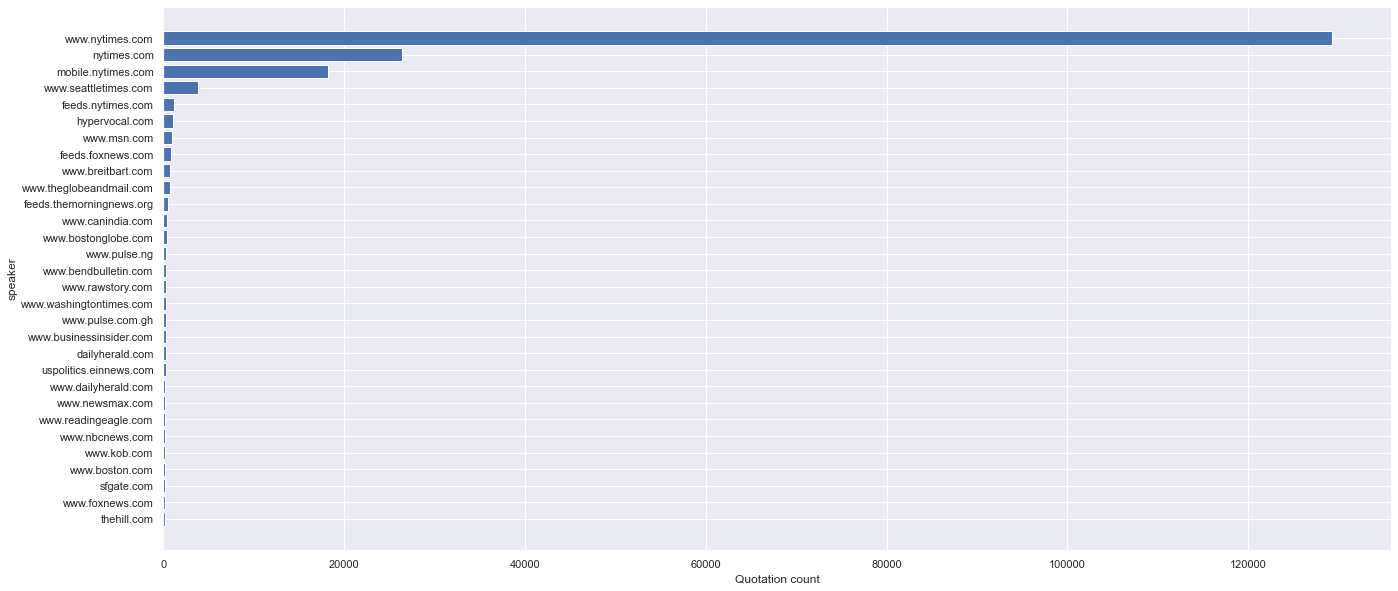

In [35]:
# plot the frequency of top 30 extract topics with respect to frequency
media_num = 30

top_k_topics = dict(sorted_medias[:media_num])
plt.figure(figsize=(22,10))
plt.xlabel('Quotation count')
plt.ylabel('speaker')
ax = plt.barh(y=list(top_k_topics.keys())[::-1], width=list(top_k_topics.values())[::-1], data=top_k_topics)

# 2019 Data Analysis

Here we start looking at a bigger scope of data, where we expect to find out some topics that are easily neglected, but still worth our attention.

In [ ]:
# load the entire 2019 dataset using trunks

with pd.read_json('data/quotes-2019.json.bz2', lines=True, compression='bz2', chunksize=1000000) as df_reader:
    topic_freq = {}
    for count, chunk_df in enumerate(df_reader):
        quote_list = chunk_df[chunk_df['speaker'] != 'None']['quotation'].str.strip().to_numpy()  # consider only non_None speakers
        count_topic_freq_from_list(quote_list, topic_freq)
  

In [ ]:
# sort the medias according to their corresponding quotation frequency
sorted_nouns_2019 = list(sorted(topic_freq.items(), key=lambda x: x[1], reverse=True))

In [ ]:
# how many topics in 2019
print(f'Total topic number of 2019 is {len(topic_freq.keys())}')

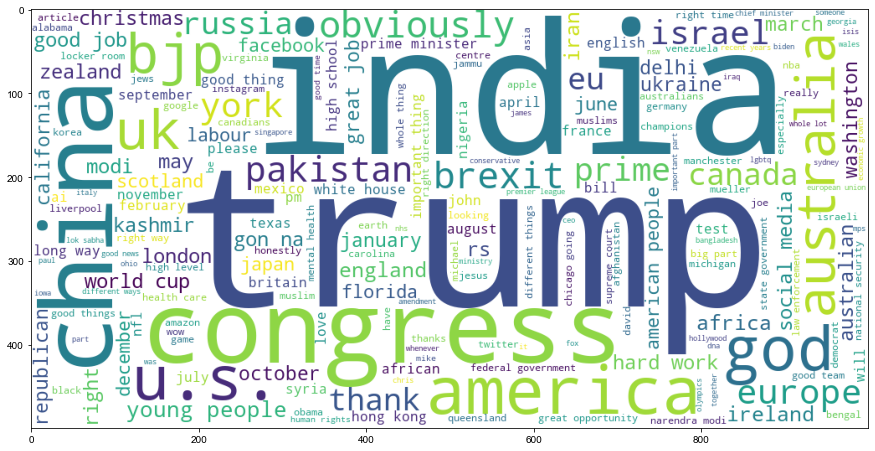

In [3]:
# # visualize the word cloud using the topic frequencies
topic_num = 200
# lgbtq start at 169
top_k_topics = dict(sorted_nouns_2019[:topic_num])  # select top-k topics
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(top_k_topics)
sns.reset_orig()
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
sns.set()
display.Image("output.png")

We plotted the top 200 topics in the 2019 QuoteBank dataset, and see what is in it. From above we see most topics are still related to politics, and also some hot concepts such as "god" and "brexit". But if you look closely at the right-bottom of the big "india" topic, you can see there is the topic of **LGBTQ**. Not obvious at first glance, but note that here are the **top 200 topics among 4668333 topics of year 2019**. This is a great achievement of people paying more attention to equality and respect, and is what we are going to study.

Now let's take a look at what is around LGBTQ topic

In [ ]:
# get the rank of LGBTQ
list(dict(sorted_nouns_2019).keys()).index(('lgbtq'))

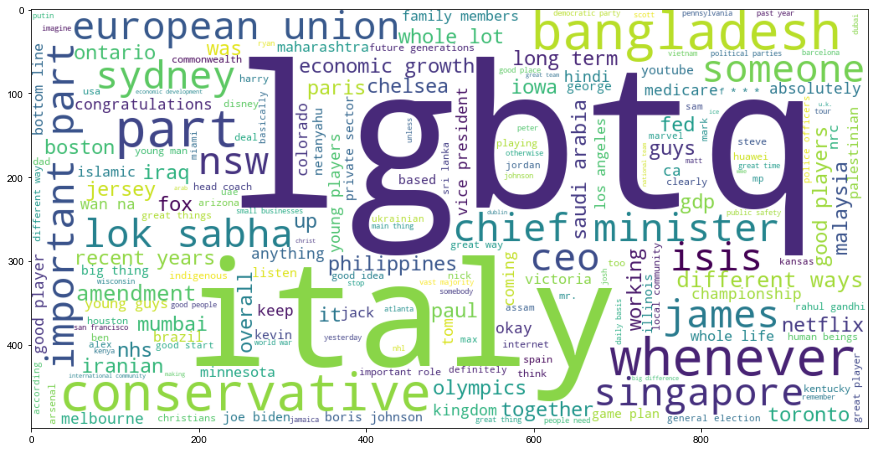

In [4]:
# visualize the word cloud using the topic frequencies
topic_num = 200
# lgbtq start at 169
top_k_topics = dict(sorted_nouns_2019[169:topic_num+169])  # select top-k topics
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(top_k_topics)
sns.reset_orig()
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
sns.set()

By plotting the topics around LGBTQ, we see that it is not so "small" as at first glance, there are even bigger than topics such as "olympics" and "economic growth". And we want to dig further to see what is really behind the topic of LGBTQ, say, who is caring about it, how it become popular, if every country in the world paid enough attention to the equality problem, and how can we improve it.

## 2. data handling pipeline

From earlier analysis, we chose LGBTQ as our subject, for this part we will bring about our research questions concerning that topic. Furthermore, we will illustrate how we are going to carry out our analysis through some examples.

### 2.1 research questions

* How does the frequency of the topic change year after year, and what might be the reason for the change.
* How do people from different groups (e.g. gender, occupation etc.) talk about LGBTQ equality problems (positive or negative). Specifically, is there any correlation between a country's financial situation or citizens' average education level and the attitudes of their people toward this topic.
* How does the pattern of the distribution of speaker features change over time, and what might be the reason accounting for it.
* What are the topics that often co-occur with LGBTQ, and the reasons for those co-occurrence. Specifically, consider those topics that co-occur with LGBTQ, does it current has a positive or negative effect
* How can we improve the situation based on the observation of above RQs

### 2.2 data handling

In this part, we will talk about the data handling pipeline we are going to use for exploring the aforementioned research questions. In the meanwhile we will give examples of the methods we will use for data analysis. 

For RQ1, since we have already extracted the quotations that talk about the LGBTQ topic, the main thing we need to do is to plot and analyze the change of the topic's frequency year after year. When considering the topic's frequency, we should also take the year's total amount of quotations into consideration, and use `(topic frequency / total quotation amount)` in our analysis.  

**RQ1**

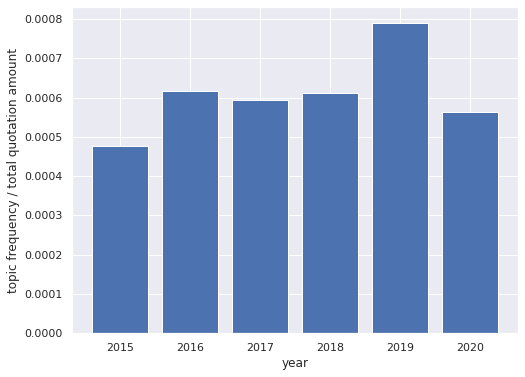

In [63]:
# here is the code for plotting the change of LGBTQ's topic frequency distribution according to year.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

# calculate the topic frequency of LGBTQ in each yeaar.
lgbtq_frequency = {}
# the total amount of quotations each year.
total_topic_num = {2015: 20874338, 2016: 13862129, 2017: 26611588, 2018: 27228451, 2019: 21763302, 2020: 5244449}
for year in range(2015, 2021):
    frequency = len(pd.read_pickle(f'./{year}/lgbt_{year}.pkl'))
    lgbtq_frequency[year] = frequency / total_topic_num[year]

plt.figure(figsize=(8,6))
plt.bar(data=lgbtq_frequency, x=list(lgbtq_frequency.keys()), height=list(lgbtq_frequency.values()))
plt.xlabel('year')
plt.ylabel('topic frequency / total quotation amount')
plt.show()

From the plot we can see that there is a sudden rise in topic frequency in 2020. We will give our hypothesis from different angles to offer possible explanations for such change in milestone 3, and then carry out an analysis to support our opinions. For example, we may hypothesize that the change is a result of some big LGBTQ inequality incidents, which drew people's attention to this topic and thus caused this frequency rise. To support our idea, we need to first observe other possible reasons that can also cause such a result (e.g. the LGBTQ topic is no longer a forbidden topic in some areas, so more media suddenly focused more on this topic in 2019). After the confounder observation, we need to wisely choose a subset of the data to reduce the confounders' impact on our conclusion. More details of this part will be listed in milestone 3.  

**RQ2**

From now on we will deal with the speakers, so the first thing we need to do is to process the data to map the speakers with their attributes. Through the initial analysis of the dataset, the quotation whose speaker is None should be excluded. Besides, the quotation whose `qids` has a length of more than 1 should also be removed since we cannot make sure who is the real speaker. 

In [2]:
lgbt_data_2016 = pd.read_pickle('./2016/lgbt_2016.pkl')
lgbt_data_2016 = lgbt_data_2016[lgbt_data_2016['qids'].apply(lambda x: len(x) == 1)]
lgbt_data_2016.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
1,2016-09-26-045513,I was focused because I wanted this to be a fi...,Angeli Bayani,[Q17318564],2016-09-26 05:45:56,2,"[[Angeli Bayani, 0.9481], [None, 0.0427], [Rub...",[http://www.mb.com.ph/neds-project-to-compete-...,E
2,2016-07-10-027501,In the wake of the deadliest mass shooting in ...,Hillary Clinton,[Q6294],2016-07-10 11:45:42,2,"[[Hillary Clinton, 0.5323], [None, 0.273], [Mo...",[http://www.wnd.com/2016/06/hillary-abandons-l...,E
4,2016-07-09-053925,They (LGBT) are sinful patients suffering from...,Zakir Naik,[Q932829],2016-07-09 16:47:35,1,"[[Zakir Naik, 0.8553], [None, 0.1447]]",[http://www.newindianexpress.com/nation/Six-in...,E
5,2016-08-30-116361,This show definitely helps fight the stigma th...,Lance Bass,[Q443120],2016-08-30 15:01:40,2,"[[Lance Bass, 0.8887], [None, 0.1113]]",[http://feeds.towleroad.com/~r/towleroad/feed/...,E
7,2016-09-15-058162,I'm running for the LGBT teenager here in Nort...,Hillary Clinton,[Q6294],2016-09-15 11:11:10,29,"[[Hillary Clinton, 0.5737], [None, 0.2767], [C...",[http://digtriad.com/news/politics/clinton-i-t...,E


Then we can acquire the speaker's qid in the table.

In [3]:
speaker_qids_2016 = lgbt_data_2016['qids'].apply(lambda x: x[0]).to_frame()
speaker_qids_2016.head()

,qids
1,Q17318564
2,Q6294
4,Q932829
5,Q443120
7,Q6294


For matching speakers with their attributes, now we only need to load the `speaker_attributes.parquet` file and merge it with the speaker_qids_2016 dataframe.

In [4]:
speaker_attributes = pd.read_parquet('./speaker_attributes.parquet')
speaker_2016 = pd.merge(speaker_qids_2016, speaker_attributes, left_on='qids', right_on='id', how='left')
speaker_2016.head()

,qids,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,Q17318564,None,[+1953-01-01T00:00:00Z],[Q928],[Q6581072],1.318454e+09,None,None,"[Q33999, Q10800557]",None,None,Q17318564,Angeli Bayani,None,item,None
1,Q6294,"[Hillary Rodham Clinton, Hillary Rodham, Hilla...",[+1947-10-26T00:00:00Z],[Q30],[Q6581072],1.393847e+09,None,C001041,"[Q82955, Q40348, Q193391, Q36180, Q18814623, Q...","[Q29552, Q29468]","[Q163727, Q1540185]",Q6294,Hillary Clinton,"[Q699872, Q4791768]",item,[Q33203]
2,Q932829,[Zakir Abdul Karim Naik],[+1965-10-18T00:00:00Z],"[Q668, Q851]",[Q6581097],1.381263e+09,[Q1265028],None,"[Q39631, Q36180, Q58968, Q432386, Q774306, Q46...",None,None,Q932829,Dr. Zakir Naik,None,item,[Q432]
3,Q443120,None,[+1979-05-04T00:00:00Z],[Q30],[Q6581097],1.391312e+09,None,None,"[Q3282637, Q10800557, Q177220, Q5716684, Q2405...",None,None,Q443120,Lance Bass,None,item,None
4,Q6294,"[Hillary Rodham Clinton, Hillary Rodham, Hilla...",[+1947-10-26T00:00:00Z],[Q30],[Q6581072],1.393847e+09,None,C001041,"[Q82955, Q40348, Q193391, Q36180, Q18814623, Q...","[Q29552, Q29468]","[Q163727, Q1540185]",Q6294,Hillary Clinton,"[Q699872, Q4791768]",item,[Q33203]


Then we need to make sure if every speaker has been mapped to their label. 

In [5]:
speaker_2016[speaker_2016['label'].isnull()]['qids'].to_frame()

,qids
181,Q56513386
301,Q56513386
662,Q47114873
685,Q47114873
1046,Q16193340


Clearly, the amount of unmapped speakers is small. And from what we have learned, the missing qids can either be a result of redirecting wikidata webpage (two different qids can point to the same person), or due to a missing profile (the profile about the speaker can be totally deleted). As a result, we decided to manually deal with those qids.

After mapping the speakers with their attributes, the next thing we need to do is replacing the qids in speakers' attributes with their labels. For this part we need the `wikidata_labels_descriptions.csv.bz2` file. Since the file is too large to put into memory, we need to deal with it in chunks and care more about efficiency when storing the qids and their labels. Basically we will first get all the qids needed, and build a dictionary where the keys are qids and the default value is None. The wikidata dataset will be explored iteratively in chunks and the qids' value in the dictionary will be updated with their labels. After the iteration is done, qids with the value None will be recorded as unmapped. 

In [6]:
col_label = ['nationality', 'gender', 'occupation', 'ethnic_group', 'party', 'academic_degree', 'candidacy', 'religion']

def get_item_qids(df):
    # do not consier rows with NaN in colomn label
    clean_df = df[df['label'].notnull()]
    item_qids = []
    for index, row in clean_df.iterrows():
        item_qids_row = []
        for label in col_label:
            if row[label] is not None:
                item_qids_row += row[label].tolist()
        item_qids += item_qids_row
    return list(set(item_qids))

def replace_qids(df, qids_dict):
    clean_df = df[df['label'].notnull()]
    for index, row in clean_df.iterrows():
        for label in col_label:
            new_array = []
            if row[label] is None:
                continue
            for qid in row[label]:
                if qids_dict[qid] is None:
                    new_array.append(qid)
                else:
                    new_array.append(qids_dict[qid])
            row[label] = np.array(new_array)
        df.iloc[index] = row

item_qids_2016 = get_item_qids(speaker_2016)
qids_dict_2016 = dict(zip(item_qids_2016, [None for i in range(len(item_qids_2016))]))

with pd.read_csv('wikidata_labels_descriptions.csv.bz2', compression='bz2', sep=',', chunksize=5000000) as df_reader:
    for chunk in tqdm(df_reader):
        for index, row in chunk.iterrows():
            if row['QID'] in qids_dict_2016:
                qids_dict_2016[row['QID']] = row['Label']

replace_qids(speaker_2016, qids_dict_2016)
speaker_2016.head()

,qids,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,Q17318564,None,[+1953-01-01T00:00:00Z],[Philippines],[female],1.318454e+09,None,None,"[actor, film actor]",None,None,Q17318564,Angeli Bayani,None,item,None
1,Q6294,"[Hillary Rodham Clinton, Hillary Rodham, Hilla...",[+1947-10-26T00:00:00Z],[United States of America],[female],1.393847e+09,None,C001041,"[politician, lawyer, diplomat, writer, autobio...","[Democratic Party, Republican Party]","[bachelor's degree, Juris Doctor]",Q6294,Hillary Clinton,"[2016 United States presidential election, 200...",item,[Methodism]
2,Q932829,[Zakir Abdul Karim Naik],[+1965-10-18T00:00:00Z],"[India, Saudi Arabia]",[male],1.381263e+09,[Marathi people],None,"[physician, writer, intellectual, preacher, su...",None,None,Q932829,Dr. Zakir Naik,None,item,[Islam]
3,Q443120,None,[+1979-05-04T00:00:00Z],[United States of America],[male],1.391312e+09,None,None,"[film producer, film actor, singer, dancer, vo...",None,None,Q443120,Lance Bass,None,item,None
4,Q6294,"[Hillary Rodham Clinton, Hillary Rodham, Hilla...",[+1947-10-26T00:00:00Z],[United States of America],[female],1.393847e+09,None,C001041,"[politician, lawyer, diplomat, writer, autobio...","[Democratic Party, Republican Party]","[bachelor's degree, Juris Doctor]",Q6294,Hillary Clinton,"[2016 United States presidential election, 200...",item,[Methodism]


Now we need to see how many qids for features are not mapped.

In [9]:
missing_item_qids_2016 = []
for key, val in qids_dict_2016.items():
    if val is None:
        missing_item_qids_2016.append(key)
missing_item_qids_2016

[]


Clearly the amount of missing items is not large (0 for 2016), so we will also manually look them up.

After acquiring the speakers with their corresponding features, we will need some sentimental analysis tools to check the speakers' attitudes towards LGBTQ. For this part we will use google cloud's [natural language api](https://cloud.google.com/natural-language/docs/sentiment-tutorial). The `analyze_sentiment` function will return a score and a magnitude for the given quotation. The score ranges from -1 to 1, which indicates the overall emotion of the quotation. The magnitude indicates how much emotional content is present within the quotation. The two values should both be taken into consideration when studying a quotation's emotion since the overall emotion of a quotation can also be near 0 when the positive and negative parts cancel each other out. Here we set two values `NEUTRAL` and `MIXED` for labeling attitudes to each quotation. When the absolute value of the score is less than `NEUTRAL`, we will check if the magnitude is less than `MIXED`, if so the quotation will be labeled as neutral, otherwise mixed. For quotations whose score is bigger than `NEUTRAL`, we just label the quotation's attitude according to whether it is positive or negative.

In [ ]:
NEUTRAL = 0.1
MIXED = 0.1
from google.cloud import language_v1

# for this part no input df should contain NaN label
def add_attitudes(df):
    client = language_v1.LanguageServiceClient()
    df.insert(1, 'attitude', None)
    for index, row in tqdm(df.iterrows()):
        quotation = row['quotation']
        document = language_v1.Document(content=quotation, type_=language_v1.Document.Type.PLAIN_TEXT)
        try:
            annotations =  client.analyze_sentiment(request={'document': document})
        except:
            continue

        score = annotations.document_sentiment.score
        magnitude = annotations.document_sentiment.magnitude
        label = 0 # -1:negative, 0:neutral, 1:positive, 2:mixed
        if abs(score) <= NEUTRAL:
            if abs(magnitude) <= MIXED:
                label = 0
            else:
                label = 2
        else:
            if score < 0:
                label = -1
            else:
                label = 1
        row['attitude'] = label
        try:
            df.iloc[index] = row
        except:
            print('wrong index is %d' % index)

During the processing there will be some quotations that the api cannot deal with (e.g. `Naniniwla ako na ang Destiny Rose ay magiging instrumento para buksan ang iba pang mga isip lalo na dito sa Pilipinas, na buksan ang isip nila sa same-sex marriage, sa LGBT, para magkaroon ng equality.`). Since those sentences only take up a small portion of all the data, we will simply remove those rows. 

Now we have labeled the speakers with their quotations' attitudes toward LGBTQ, we can plot the attitudes distribution according to their features, here we give an example plot of the distribution of different countries' people's attitudes toward this topic. In order to make the feature distribution more comparable, we calculate the portion of positive and negative attitudes in each feature category.   

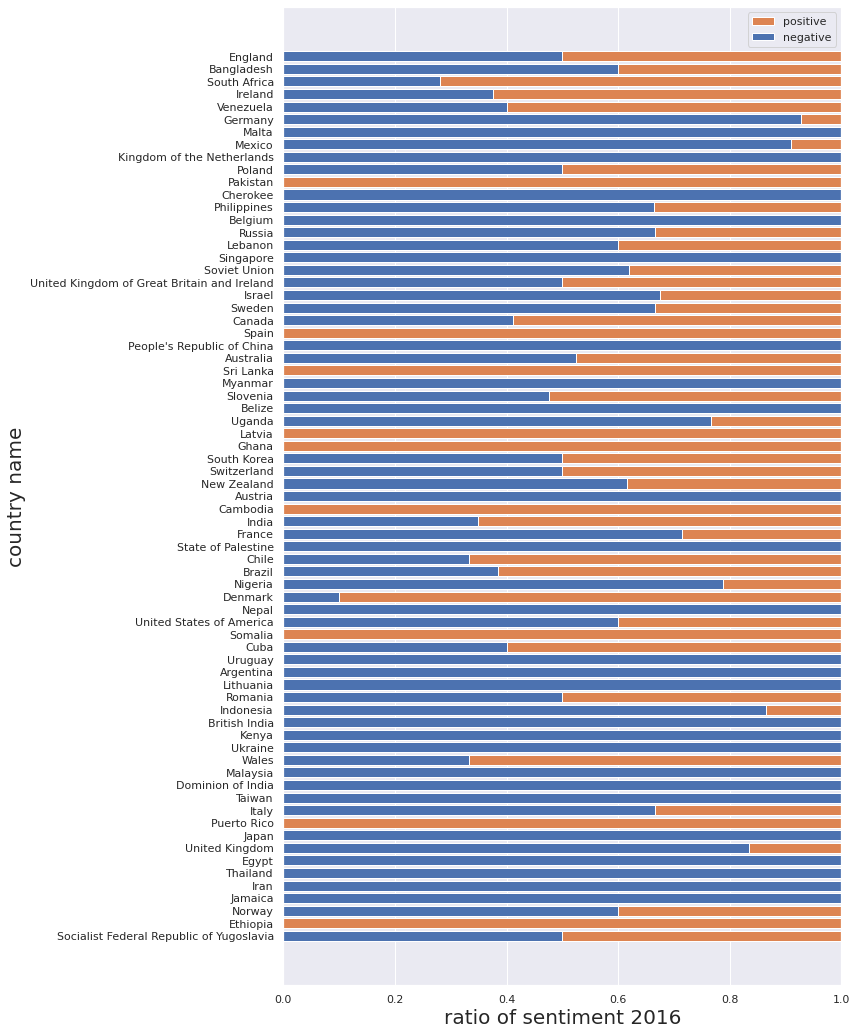

In [58]:
import numpy as np
from collections import defaultdict
def plot_nation_attitude(atti_df, nation_df, year):
    nation_atti_pos = defaultdict(lambda: 0)
    nation_atti_neg = defaultdict(lambda: 0)
    merge_df = pd.merge(atti_df, nation_df, left_on='speaker', right_on='label', how='inner')
    for i, row in merge_df[['attitude','nationality']].iterrows():
        if row['nationality'] is None or type(row['nationality']) is float:
            continue
        for nation in list(row['nationality']):
            if row['attitude'] == 1:
                nation_atti_pos[nation] += 1
            if row['attitude'] == -1:
                nation_atti_neg[nation] += 1
    
    # normalize
    keys = set(nation_atti_pos.keys()).union(set(nation_atti_neg.keys()))
    nation_atti_pos_temp = {}
    nation_atti_neg_temp = {}
    for key in keys:
        nation_atti_pos_temp[key] = nation_atti_pos[key] if key in nation_atti_pos else 0
        nation_atti_neg_temp[key] = nation_atti_neg[key] if key in nation_atti_neg else 0

    nation_atti_pos_norm = dict([
        (x[0],x[1]/(nation_atti_neg_temp[x[0]]+x[1])) for x in nation_atti_pos_temp.items()
    ])
    nation_atti_neg_norm = dict([
        (x[0],x[1]/(nation_atti_pos_temp[x[0]]+x[1])) for x in nation_atti_neg_temp.items()
    ])
    plt.figure(figsize=(10, 18))
    plt.xlabel(f'ratio of sentiment {year}', fontsize=20)
    plt.ylabel('country name', fontsize=20)
    
    
    neg = plt.barh(y=list(nation_atti_neg_norm.keys()), width=list(nation_atti_neg_norm.values()))
    pos = plt.barh(y=list(nation_atti_pos_norm.keys()), width=list(nation_atti_pos_norm.values()), left=list(nation_atti_neg_norm.values()))
    plt.legend([pos, neg],['positive', 'negative'])

lgbt_sentiment_2016 = pd.read_pickle('./2016/lgbt_sentiment_2016.pkl')
speaker_df = pd.read_pickle('2016/speaker_ph1_2016.pkl')
plot_nation_attitude(lgbt_sentiment_2016, speaker_df, 2016)

### Does the economic situation affect LGBTQ?

For exploring the correlation between a country's financial situation or citizens' average education level and the attitudes of their people toward this topic, we need to first have some information about those countries. That information is easily found through google. For instance, this [wiki page](https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)) shows the information about the ranking of each country's GDP per capita. After getting that information, we can use methods like t-test to check their correlation.

Here we give an example of learning the correlation of GDP and LGBTQ quotation frequency. We use the 2016 data here, while in the final analysis, we will consider more factors with a wider time range. **Here we use the speakers' nationality to represent a data point from a certain country**.

As a common intuition, we would speculate that countries with a better economy would have a better LGBTQ environment. From this intuition, we would suppose that countries with high GDP per capita related in higher quotation frequency of LGBTQ topics. Now let's validate it. 

In [2]:
# load speaker side-info
import pickle5

speaker_df = pickle5.load(open('data/speaker_2016.pkl', 'rb'))
speaker_df.head()

,qids,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,Q17318564,None,[+1953-01-01T00:00:00Z],[Philippines],[female],1.318454e+09,None,None,"[actor, film actor]",None,None,Q17318564,Angeli Bayani,None,item,None
1,Q6294,"[Hillary Rodham Clinton, Hillary Rodham, Hilla...",[+1947-10-26T00:00:00Z],[United States of America],[female],1.393847e+09,None,C001041,"[politician, lawyer, diplomat, writer, autobio...","[Democratic Party, Republican Party]","[bachelor's degree, Juris Doctor]",Q6294,Hillary Clinton,"[2016 United States presidential election, 200...",item,[Methodism]
2,Q932829,[Zakir Abdul Karim Naik],[+1965-10-18T00:00:00Z],"[India, Saudi Arabia]",[male],1.381263e+09,[Marathi people],None,"[physician, writer, intellectual, preacher, su...",None,None,Q932829,Dr. Zakir Naik,None,item,[Islam]
3,Q443120,None,[+1979-05-04T00:00:00Z],[United States of America],[male],1.391312e+09,None,None,"[film producer, film actor, singer, dancer, vo...",None,None,Q443120,Lance Bass,None,item,None
4,Q6294,"[Hillary Rodham Clinton, Hillary Rodham, Hilla...",[+1947-10-26T00:00:00Z],[United States of America],[female],1.393847e+09,None,C001041,"[politician, lawyer, diplomat, writer, autobio...","[Democratic Party, Republican Party]","[bachelor's degree, Juris Doctor]",Q6294,Hillary Clinton,"[2016 United States presidential election, 200...",item,[Methodism]


In [49]:
# define functions for counting country-quotation frequency

def get_country_freq(speaker_df, nation_freq):
    """
    :param speaker_df: speaker dataframe related to certain topic
    :nation_freq: dict storing the frequency nationalities of quotation speakers
    """
    for i, row in speaker_df.iterrows():
        if row['nationality'] is None or type(row['nationality']) == float:
            continue
        for nation in list(row['nationality']):
            if nation in nation_freq.keys():
                nation_freq[nation] += 1
            else:
                nation_freq[nation] = 1

In [50]:
# count the LGBTQ quotation frequency from countries
nation_freq = {}
get_country_freq(speaker_df, nation_freq)

In [67]:
# we use the WBGAPI to get access to world bank data
import wbgapi as wb
gdp_2016 = wb.data.DataFrame('NY.GDP.PCAP.CD')['YR2016'] # 2016 gdp of different countries

In [140]:
# get russian's gdp per capita
gdp_2016['RUS']

8704.89841329594

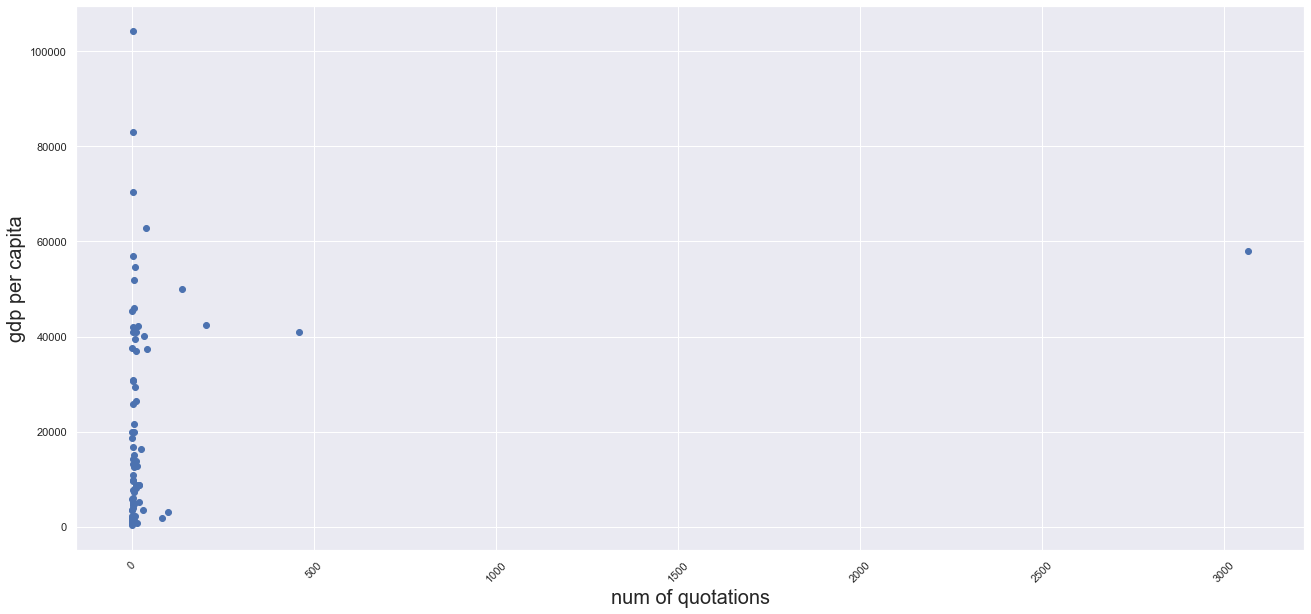

In [176]:
gdps = []
quotations = []
nation_freq = dict(sorted(nation_freq.items(), key=lambda x: x[1])[::-1])
for key in nation_freq.keys():
    country_code = wb.economy.coder([key])[key]
    if country_code not in gdp_2016.keys():
        continue
    gdp = gdp_2016[country_code]
    gdps.append(gdp)
    quotations.append(nation_freq[key])

plt.figure(figsize=(22,10))
plt.xticks(rotation=45)
plt.xlabel('num of quotations', fontsize=20)
plt.ylabel('gdp per capita', fontsize=20)
plt.scatter(x=quotations, y=gdps)

From this plot we can not see any pattern, as the quotation number of different countries varies a lot. And here we normalize the lgbtq quotation ratio by dividing the overall quotation number of that certain country.

$$
lgbt\_ratio(country) = \frac{\#quotation(LGBT, country)}{\#quotation(\cdot, country)}
$$

In [174]:
YEAR = 2016
speaker_df = pickle5.load(open(f'data/all_speaker_{2016}.pkl', 'rb'))
speaker_df.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,religion
0,None,[+1965-08-21T00:00:00Z],[United States of America],[Q6581097],1.316858e+09,None,None,[Q177220],None,None,Q6847325,Mike Howe,None,None
1,"[Hillary Rodham Clinton, Hillary Rodham, Hilla...",[+1947-10-26T00:00:00Z],[United States of America],[Q6581072],1.393847e+09,None,C001041,"[Q82955, Q40348, Q193391, Q36180, Q18814623, Q...","[Q29552, Q29468]","[Q163727, Q1540185]",Q6294,Hillary Clinton,"[Q699872, Q4791768]",[Q33203]
2,[Bruce Tyrone Maxwell],[+1990-12-20T00:00:00Z],None,[Q6581097],1.378324e+09,None,None,[Q11336312],None,None,Q26129591,Bruce Maxwell,None,None
3,None,[+1933-09-22T00:00:00Z],[United States of America],[Q6581097],1.392058e+09,None,None,"[Q33999, Q486748]",None,None,Q2059029,Paul Bryant,None,None
4,[Stephon Xavier Marbury],[+1977-02-20T00:00:00Z],[United States of America],[Q6581097],1.389302e+09,[Q49085],None,[Q3665646],None,None,Q319336,Stephon Marbury,None,None


In [120]:
all_nation_freq = {}
get_country_freq(speaker_df, all_nation_freq)
all_nation_freq = dict(sorted(all_nation_freq.items(), key=lambda x: x[1])[::-1])

In [142]:
all_nation_freq = dict(list(all_nation_freq.items())[::-1])
nation_freq = dict(list(nation_freq.items())[::-1])

In [180]:
quote_ratios = sorted([(k, nation_freq[k]/all_nation_freq[k]) for k in nation_freq.keys() if all_nation_freq[k]>10], key=lambda x: x[1])
quote_ratios

[('British India', 3.422899195618689e-05),
 ('Dominion of India', 4.313691657320335e-05),
 ('Kenya', 5.654509471303364e-05),
 ('Malaysia', 5.733780568217654e-05),
 ('Italy', 7.587109500957873e-05),
 ('Ghana', 7.904513477195479e-05),
 ('Austria', 9.377344336084021e-05),
 ('Pakistan', 0.00010176735981546185),
 ('Turkey', 0.000121153380179307),
 ('Switzerland', 0.0001350438892640108),
 ('Colombia', 0.00014421690222094028),
 ('France', 0.00014945246053096382),
 ('Singapore', 0.00015489467162329616),
 ('Ukraine', 0.0001592103168285305),
 ('Scotland', 0.00017140898183064793),
 ('Kingdom of the Netherlands', 0.00017466638720044716),
 ('Taiwan', 0.00020197939810139365),
 ('Germany', 0.00022241718049154197),
 ('Spain', 0.000224981081136359),
 ('Czech Republic', 0.000228675966155957),
 ('Iran', 0.0002438132390588809),
 ('Nigeria', 0.00026417752729834446),
 ('Sweden', 0.00026636833413243836),
 ('Jamaica', 0.00026925148088314486),
 ('Egypt', 0.00028074115665356543),
 ('South Africa', 0.00028204766

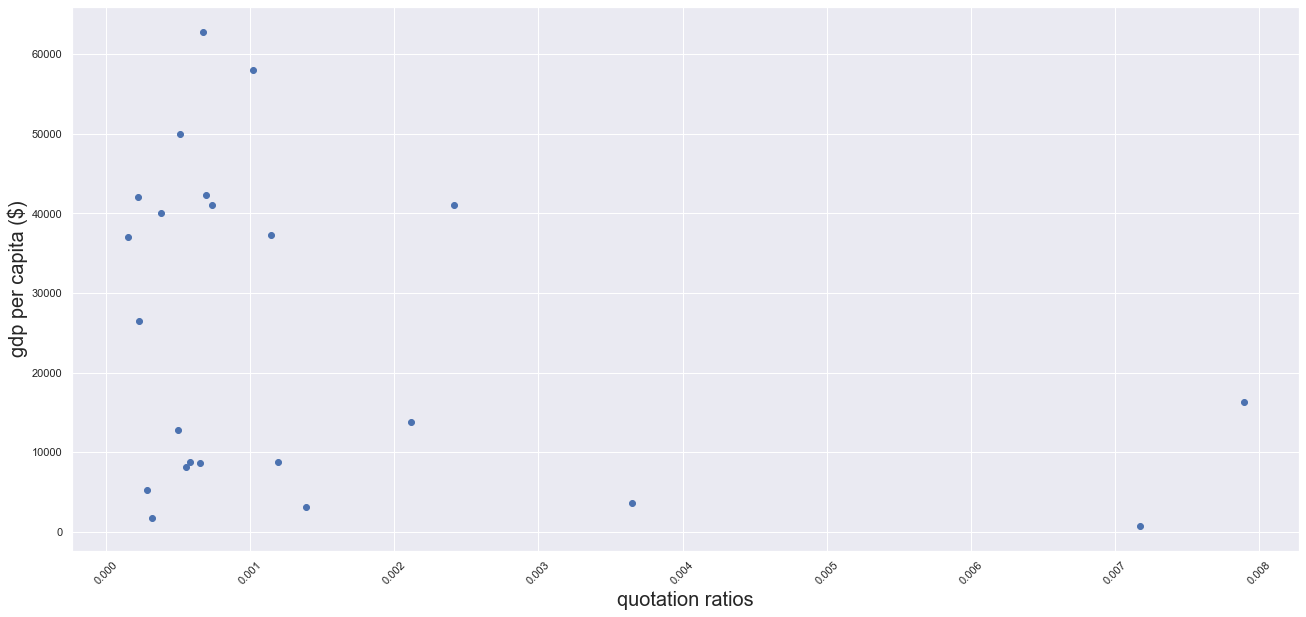

In [191]:
gdps = []
quotation_ratios = []
for key in nation_freq.keys():
    country_code = wb.economy.coder([key])[key]
    if country_code not in gdp_2016.keys():
        continue
    gdp = gdp_2016[country_code]
    if nation_freq[key] < 10 or np.isnan(gdp):
        continue
    quote_ratio = round(nation_freq[key]/all_nation_freq[key],7)
    # if quote_ratio > 0.005:
    #     continue
    gdps.append(gdp)
    quotation_ratios.append(quote_ratio)

plt.figure(figsize=(22,10))
plt.xticks(rotation=45)
plt.xlabel('quotation ratios',fontsize=20)
plt.ylabel('gdp per capita ($)',fontsize=20)
plt.scatter(x=quotation_ratios, y=gdps)

From the plot we could see there does not exist an obvious positive correlation toward gdp per capita and lgbtq-related quotations. More rigorously, we use Pearson correlation accompanied with a double side t-test to evaluate the relationship.

In [168]:
# use pearson correlation to evaluate the correlations
import scipy
scipy.stats.pearsonr(x=gdps, y=quotation_ratios)

(-0.2654934138023842, 0.08925962812048845)

What a surprise! Contrary to our intuition, there even exists a slight negative correlation between GDP and lgbtq quotation rates. What is happening here? Now we look deeper into the low-gdp countries with high lgbtq quotation rates.

In [193]:
quotation_ratios = []
for key in nation_freq.keys():
    country_code = wb.economy.coder([key])[key]
    if country_code not in gdp_2016.keys():
        continue
    if nation_freq[key] < 20 or np.isnan(gdp):  # skip countries with too low lgbtq quotations
        continue
    quote_ratio = round(nation_freq[key]/all_nation_freq[key],6)
    quotation_ratios.append((key, quote_ratio))

lgbtq_quote_countries = sorted(quotation_ratios,key=lambda x: x[1])[::-1]
lgbtq_quote_countries[:3]

[('Trinidad and Tobago', 0.007893),
 ('Indonesia', 0.003646),
 ('Philippines', 0.001385)]

After searching for LGBTQ environment in these three countries, including social status, legitimations and lgbtq ratios, we found that the high-quotation rate actually related to the high contractions in the LGBTQ culture lying in the society of these countries. 

For example, legislation supporting same-sex marriage in the Philippines has been proposed several times in the Philippine legislature until 2010, none has been passed. However, the Philippines has been ranked one of the most gay-friendly nations in the world and is the most gay-friendly in Asia. In a survey of 39 countries; The House of Representatives approved LGBT Rights on 20 September 2017. -- wikipedia

From this fact, we should instead dig deeper into the contents of quotations, such as semantic sentiment analysis, to find more precise relations between lgbtq and society factors.

**RQ3**

After applying earlier analysis for each year, we can study the change of speakers' features on the timeline. For example here we plot the distribution change of each country's speakers' attitudes toward that topic in 2015 and 2016.

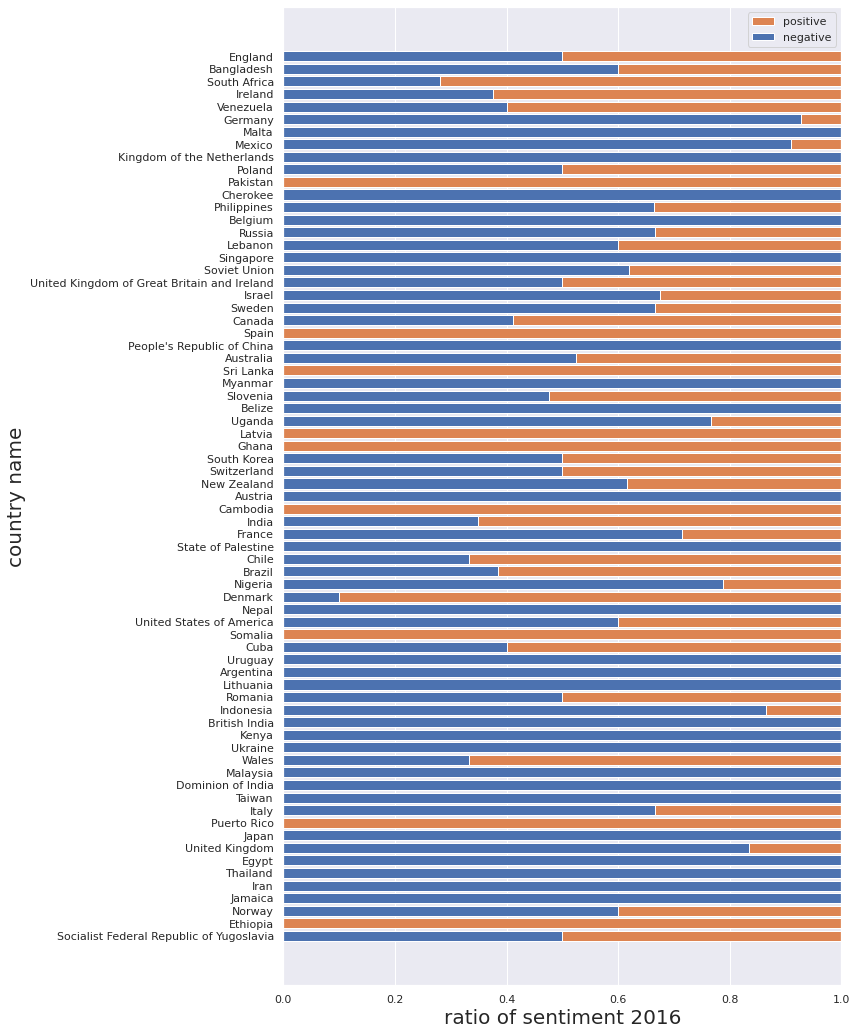

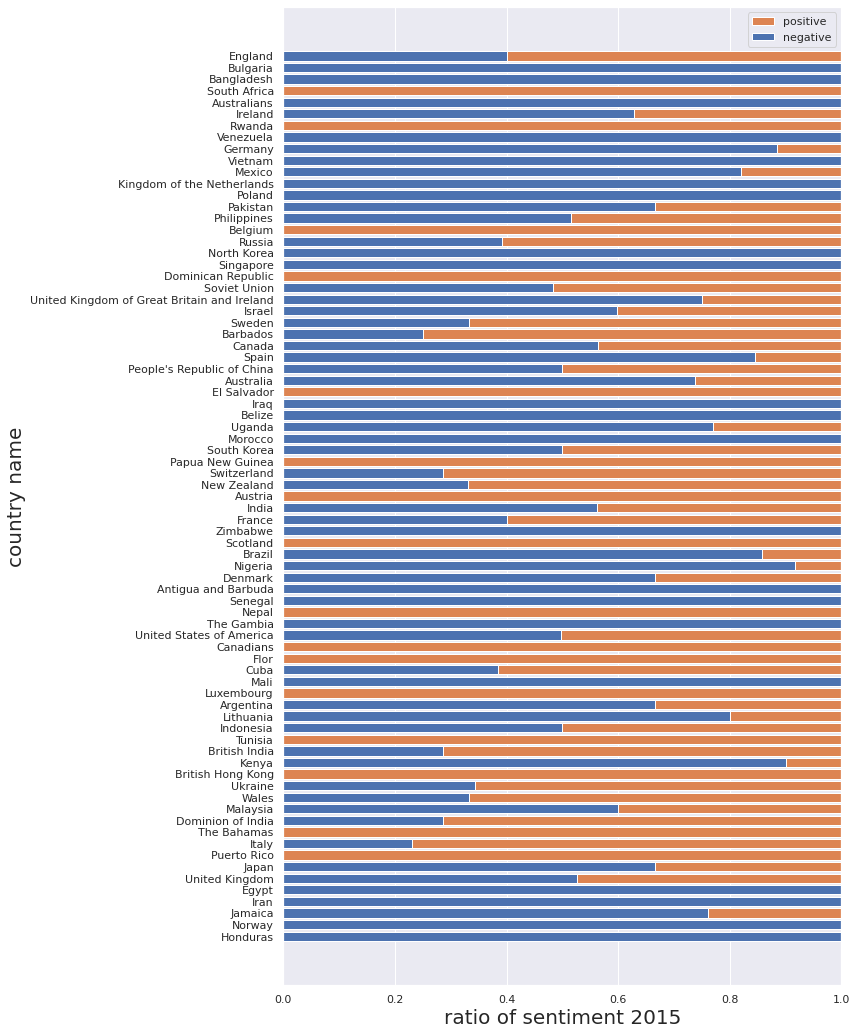

In [60]:
plot_nation_attitude(lgbt_sentiment_2016, speaker_df, 2016)
lgbt_sentiment_2015 = pd.read_pickle('./2015/lgbt_sentiment_2015.pkl')
speaker_df_2015 = pd.read_pickle('2015/speaker_ph1_2015.pkl')
plot_nation_attitude(lgbt_sentiment_2015, speaker_df_2015, 2015)

From the above plots we can see that countries like Spain have more portions of positive attitudes in 2016 than in 2015. When studying the possible reasons for the change, we should follow a similar procedure as dealing with RQ1 in order to draw a sound conclusion. 

**RQ4**

Here we give an example of analysis toward the topics that co-occur with LGBTQ.

Instead of what we have done in the frequent topic extraction phase, here we want to be more precise and convincing about the topics that we extracted. Further, we want to give more reasoning to them, and one way for doing this is to use topic aggregations. Here we directly apply the integrated API as **BERT-Topic**, whose method scheme is as follows:

1. Gather LGBTQ quotations as one document (lists of quotations)
2. Performing text embedding using Transformer language models (with pretrained weight loaded)
3. Apply aggregation algorithm to text embeddings using UMAP (for dimension reduction) and HDBSAN (for clustering) algorithm
4. extract topics using class-based TF-IDF algorithm

In [2]:
# load and gathering LGBTQ quotation data 
file_list = ['lgbt_2020.pkl'] # 'lgbt_2019.pkl', 

pd_lgbt = pd.concat([pd.read_pickle("data/"+file) for file in file_list], ignore_index=True, axis=0)
pd_lgbt.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains
0,2020-01-10-072849,The Church teaches families are created by fat...,None,[],2020-01-10 15:45:19,6,"[[None, 0.6122], [Claude Barthe, 0.3878]]",[https://www.catholicregister.org/home/interna...,E,"[org, com, org, com, co.uk, com]"
1,2020-02-06-031340,I began to think about how I was taught to def...,Matthew Lopez,"[Q26847111, Q27048360, Q33093596]",2020-02-06 23:00:11,7,"[[Matthew Lopez, 0.8928], [None, 0.1072]]",[http://ctpost.com/entertainment/article/Iman-...,E,"[com, com, com, com, com, com, com]"
2,2020-01-07-054404,"Pierre is the only black, queer artist visible...",None,[],2020-01-07 10:25:00,1,"[[None, 0.6125], [Kiddy Smile, 0.3875]]",[https://mixmag.net/feature/kiddy-smile-ballro...,E,[net]
3,2020-01-31-075444,Shea Diamond's powerful story and message of r...,None,[],2020-01-31 13:00:00,2,"[[None, 0.7796], [Shea Diamond, 0.2204]]",[http://hrc.org/blog/hrc-to-honor-actress-jami...,E,"[org, org]"
4,2020-01-15-085152,The Vito Russo Award is presented to an openly...,Sarah Kate Ellis,[Q18043792],2020-01-15 22:00:00,1,"[[Sarah Kate Ellis, 0.6539], [None, 0.3234], [...",[https://www.eonline.com/news/1112090/ryan-mur...,E,[com]


In [3]:
pd_lgbt.shape

(2959, 10)

In [4]:
# transfer the data into numpy array which is compatible to the BERT model
quotation_list = pd_lgbt['quotation'].to_numpy()

In [5]:
# load and train the Bert_topic model

from bertopic import BERTopic
topic_model = BERTopic()

In [6]:
# train the BERT-topic model, this may take several minutes

topics, probs = topic_model.fit_transform(quotation_list)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


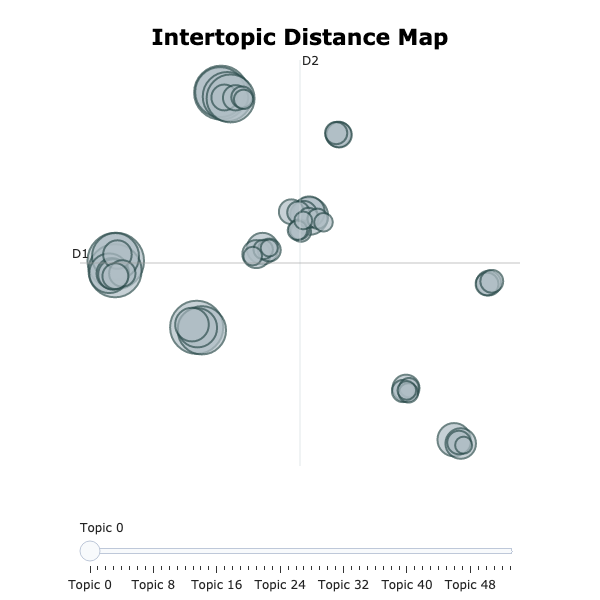

In [60]:
# visualize the topic clusters
# here we transfer the dynamic image of ploty to static ones, and the dynamic version will be used in the final html
img = topic_model.visualize_topics()
pio.write_image(img,"images/cluster.png", height=600,width=600)
display.Image("images/cluster.png")

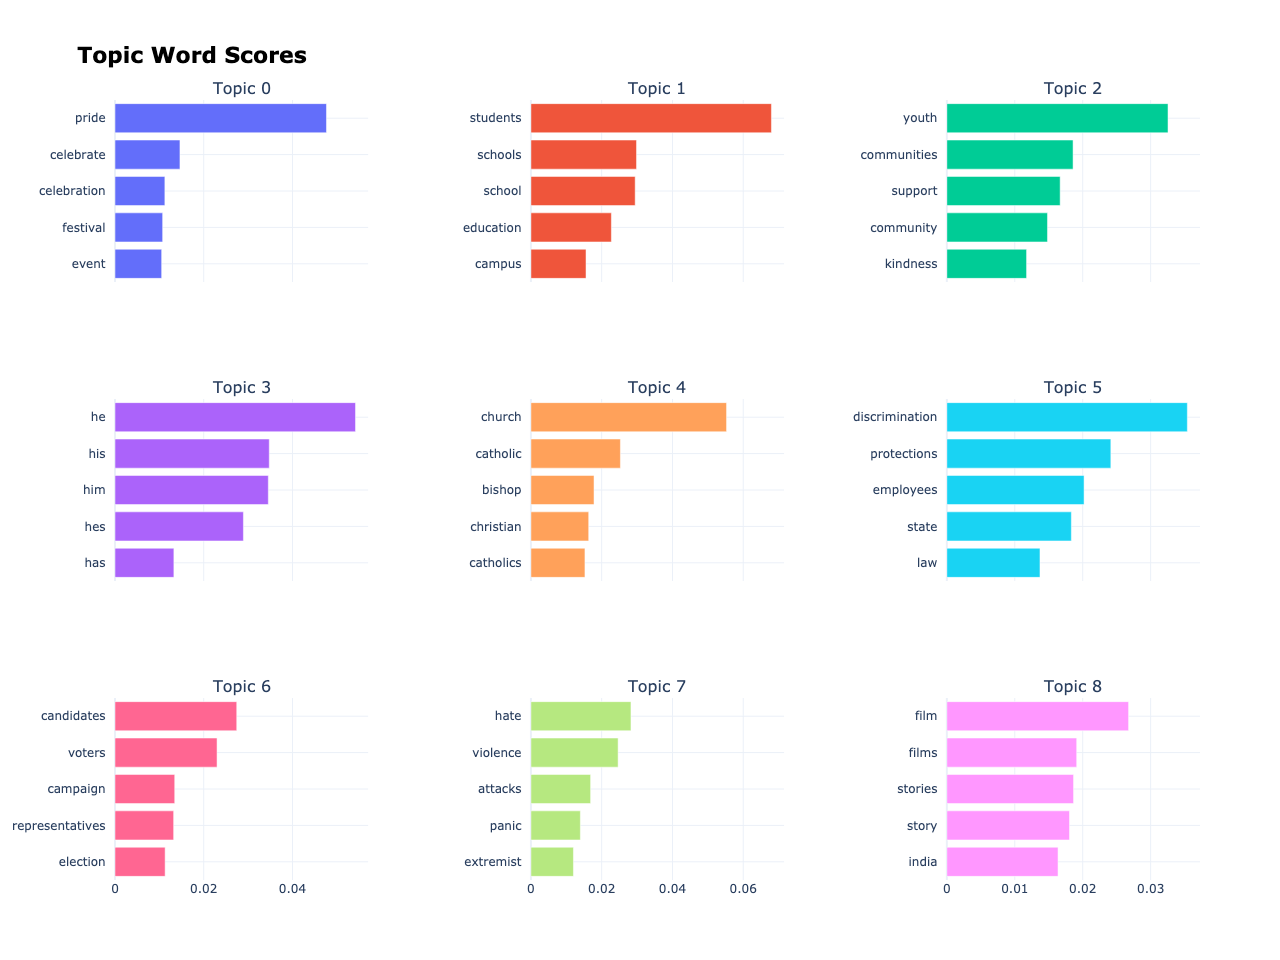

In [54]:
# now we visualize the top 9 topic clusters that occur with the LGBTQ quotations
img = topic_model.visualize_barchart([0,1,2,3,4,5,6,7,8])
pio.write_image(img,"images/bar_9.png", height=960,width=1280)
display.Image("images/bar_9.png")

In [ ]:
# probability distribution of topic cluster 5
topic_model.get_topic(5)

[('church', 0.05206398744662114),
 ('catholic', 0.025912689104983806),
 ('christian', 0.016734304382609654),
 ('gospel', 0.016644804666822454),
 ('catholics', 0.015646657178876384),
 ('lgbt', 0.012124045060964928),
 ('churches', 0.01095465191690594),
 ('biblical', 0.010305001149797509),
 ('christianity', 0.009622974054577722),
 ('heterosexual', 0.008940946959357933)]

In [ ]:
quo_church = pd_lgbt[pd_lgbt['quotation'].str.contains('church')]['quotation'].to_numpy()
for i, quote in enumerate(quo_church):
    if i < 4:
        print(quote+'\n')

We call on local, state and the federal government to serve all of their people by passing legislation that protects vital religious freedoms for individuals, families, churches and other faith groups while also protecting the rights of our LGBT citizens in such areas as housing, employment and public accommodation,

[ LGBTQ people ] are fully members of the church. It's just a question of getting people to understand that.

Wish we could say we were surprised that the vice president spoke at a church event where the bishop spouted vile things about LGBT people.,

Now that it is official church policy, will I start taking the sacrament with my right hand? Sure. Why not? I can switch-hit for the church.... I [ do ] so not because I agree this is important but because it is an easy thing my church is asking of me. This request doesn't harm anyone; it's not like I am being told to support legislation that harms LGBTQ people, for example. There are things I will not ever do for my church, 

As we could see, LGBTQ people are actually closely connected by the church topic, as churches have a non-negligible effect on legislation, membership and equality, and this is actually a big topic to deal with for achieving LGBTQ equality and protecting the rights of LGBTQ people.